---

# Analyzing Click-Through Rates for BookSends.com: Driving Value Through Data

---

#### **Background and Industry Overview**

The digital landscape is undergoing rapid transformations, with online advertising at the forefront. A testament to its significance is the expected 8% annual growth, with projections indicating the industry will eclipse $160B in annual revenue by 2023. While many consumers profess a reluctance towards clicking on ads, the reality is that the sheer volume and the long tail of the internet power the industry's triumph.

In this expansive digital arena, the Click-Through Rate (CTR) stands out as a pivotal metric. Defined as the ratio of users who engage with an advertisement to the total users exposed to it, the CTR serves as a barometer for online ad campaign success and email campaign effectiveness. Consequently, the ability to predict and optimize CTR is a prized asset, making click prediction systems invaluable for endeavors like sponsored search and real-time bidding.

#### **The BookSends.com Endeavor**

**BookSends.com** emerges as a prominent player in this space. Catering to a robust user base exceeding 300,000, the platform specializes in disseminating enticing offers — spanning free to significantly discounted e-book offers. The monetization strategy hinges on a dual approach: selling ad placements within these promotional emails and drawing revenue from both CTR and subsequent conversions.

Our collaboration with BookSends.com revolves around a central task: Harnessing historical data from 50,000 emails to model and understand the intricacies of click-through rates. The stakes are high and the objectives clear:

- Dive deep into the data to discern the inherent CTR.
- Engage in thorough Exploratory Data Analysis (EDA) to glean actionable insights.
- Sift through features to pinpoint those wielding significant influence on CTR.
- Construct, refine, and validate a predictive model tailored for CTR.

The outcomes of this analysis bear significant implications. Insights will not only inform strategies to augment future email campaigns but also provide a data-backed foundation to set advertising rates. Given our liaison with Carrie Trish Reynolds, a data-savvy lead at BookSends.com, our exploration must resonate with clarity, depth, and actionable insights.

#### **Dataset At A Glance**

While the dataset is a synthetic construct, it mirrors the complexities and nuances of real-world data. Given the industry's inherent challenge of imbalanced CTR data, pre-emptive steps like oversampling have been taken to ensure robustness in analysis.

Here's a snapshot of the data dimensions:

- **Email_ID**: A unique beacon identifying each email.
- **Subject_Marketability_score**: A quantified metric gauging the projected appeal of the email's subject.
- **Customer_Location**: A geographical marker pinpointing the recipient's state.
- ... *(Detailed descriptions for each column ensure a comprehensive understanding of the data.)*

In [1]:
import re
import time
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, KMeansSMOTE
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
    StratifiedShuffleSplit,
)
from sklearn.metrics import (
    accuracy_score,
    make_scorer,
    mean_squared_error,
    silhouette_score,
    mean_absolute_error,
    r2_score,
    recall_score,
    precision_score,
)
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, f_classif
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
# Numerical columns
num_cols = [
    "Subject_Marketability_score",
    "Total_Past_Communications",
    "Word_Count",
    "Total_Links",
    "Total_Images",
]
# Categorical columns
cat_cols = ["Customer_Location", "Signup_Site", "Genre", "Browser", "Sent_Hour"]
# Presentation colors
colors = ["#C0BDB2", "#293241", "#B9AD91", "#F8F6EF", "#EBECF0"]
# create the colormap
custom_cmap_cluster = LinearSegmentedColormap.from_list(
    "custom_cmap", [colors[-1], colors[1]]
)
custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap", [colors[1], colors[-1], colors[0]]
)

In [3]:
tech_df = pd.read_csv("online_ad.csv")

In [4]:
print(tech_df.info())
print(tech_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Email_ID                     50000 non-null  int64  
 1   Subject_Marketability_score  49967 non-null  float64
 2   Customer_Location            49968 non-null  object 
 3   Total_Past_Communications    49974 non-null  float64
 4   Word_Count                   49968 non-null  float64
 5   Total_Links                  49971 non-null  float64
 6   Total_Images                 49975 non-null  float64
 7   Signup_Site                  49963 non-null  object 
 8   Genre                        49972 non-null  object 
 9   Sent_Hour                    49981 non-null  object 
 10  Browser                      49970 non-null  object 
 11  y_click                      50000 non-null  int64  
dtypes: float64(5), int64(2), object(5)
memory usage: 4.6+ MB
None
           E

### Basics

In [5]:
# Boxplot function
def plot_boxplot(
    data,
    x_column,
    y_column,
    figsize=(8, 6),
    plot_stripplot=False,
    xlabel=None,
    ylabel=None,
    plot_name=None,
    **kwargs,
):
    plt.figure(figsize=figsize, facecolor=kwargs.get("background_color", colors[-2]))
    plt.gca().set_facecolor(
        kwargs.get("background_color", colors[-2])
    )  # Set background color
    for idx, spine in enumerate(plt.gca().spines.values()):
        if idx in [1, 3]:
            spine.set_visible(False)
        else:
            spine.set_edgecolor(kwargs.get("spine_color", colors[0]))
    ranks = data.groupby(x_column)[y_column].mean().sort_values()[::-1].index
    sns.boxplot(
        x=x_column,
        y=y_column,
        data=data,
        color=kwargs.get("box_color", colors[2]),
        order=ranks,
    )
    if plot_stripplot:
        sns.stripplot(
            x=x_column,
            y=y_column,
            data=data,
            color=kwargs.get("strip_color", colors[1]),
            order=ranks,
        )
    plt.xticks(fontsize=kwargs.get("xtick_fontsize", 10))
    plt.yticks(fontsize=kwargs.get("ytick_fontsize", 10))
    plt.xlabel(xlabel, fontsize=kwargs.get("xlabel_fontsize", 12))
    plt.ylabel(ylabel, fontsize=kwargs.get("ylabel_fontsize", 12))
    if plot_name:
        plt.savefig(
            f"graphs_2/{plot_name}.png",
            bbox_inches="tight",
            facecolor=kwargs.get("background_color", colors[-2]),
        )
    plt.show()


# Bar graph function
def plot_bar(
    data,
    x_column,
    figsize=(8, 6),
    bar_kind="bar",
    y_column=None,
    color_mapping=None,
    xlabel=None,
    ylabel=None,
    plot_name=None,
    **kwargs,
):
    plt.figure(facecolor=kwargs.get("background_color", colors[-2]))
    plt.gca().set_facecolor(
        kwargs.get("background_color", colors[-2])
    )  # Set background color
    for idx, spine in enumerate(plt.gca().spines.values()):
        if idx in [1, 3]:
            spine.set_visible(False)
        else:
            spine.set_edgecolor(kwargs.get("spine_color", colors[0]))
    if color_mapping:
        cmap_bar = LinearSegmentedColormap.from_list(
            "custom_cmap",
            [
                kwargs.get("linear_color_0", colors[1]),
                kwargs.get("linear_color_1", colors[3]),
            ],
        )
        groups_index = list(
            data.groupby(x_column)[x_column].count().sort_values(ascending=False).index
        )
        group_values_by_rank = (
            data.groupby(x_column)[y_column].mean().loc[groups_index].values
        )
        data.groupby(x_column)[x_column].count().sort_values(ascending=False).plot(
            kind=bar_kind,
            figsize=figsize,
            color=cmap_bar(
                (group_values_by_rank - group_values_by_rank.min())
                / (group_values_by_rank.max() * 2 - group_values_by_rank.min())
            ),
        )
    else:
        data.groupby(x_column)[x_column].count().sort_values(ascending=False).plot(
            kind=bar_kind,
            figsize=figsize,
            color=kwargs.get("linear_color_0", colors[1]),
        )
    plt.xticks(
        fontsize=kwargs.get("xtick_fontsize", 10),
        rotation=kwargs.get("xtick_rotation", "horizontal"),
    )
    plt.yticks(
        fontsize=kwargs.get("ytick_fontsize", 10),
        rotation=kwargs.get("ytick_rotation", "horizontal"),
    )
    plt.xlabel(xlabel, fontsize=kwargs.get("xlabel_fontsize", 12))
    plt.ylabel(ylabel, fontsize=kwargs.get("ylabel_fontsize", 12))
    if plot_name:
        plt.savefig(
            f"graphs_2/{plot_name}.png",
            bbox_inches="tight",
            facecolor=kwargs.get("background_color", colors[-2]),
        )
    plt.show()


# Corr plot function
def plot_corr(df, figsize=(9, 9), mask=None, plot_name=None, **kwargs):
    corr = df.corr()
    if mask:
        mask = np.triu(
            np.ones_like(corr, dtype=bool)
        )  # Generate a mask for the upper triangle
    # Set up the matplotlib figure
    f, ax = plt.subplots(
        figsize=figsize, facecolor=kwargs.get("background_color", colors[-2])
    )

    ax.set_facecolor(kwargs.get("background_color", colors[-2]))  # Set background color

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
        corr,
        cmap=custom_cmap_cluster,
        vmax=0.3,
        center=0,
        mask=mask,
        square=True,
        linewidths=0,
        cbar_kws={"shrink": 0.5},
    )
    if plot_name:
        plt.savefig(
            f"graphs_2/{plot_name}.png",
            bbox_inches="tight",
            facecolor=kwargs.get("background_color", colors[-2]),
        )

In [8]:
# Create new features from the missing values
for col in tech_df.columns[1:-1]:
    tech_df[col + "_was_missing"] = tech_df[col].isnull().astype(int)

tech_df = tech_df.drop(columns="Email_ID")

In [9]:
# Instantiate the imputers
# Imput the missing values with the k-Nearest Neighbors method
num_imputer = KNNImputer(n_neighbors=7)
# num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy="most_frequent")

# Impute numerical columns
tech_df[num_cols] = num_imputer.fit_transform(tech_df[num_cols])

# Impute categorical columns
tech_df[cat_cols] = cat_imputer.fit_transform(tech_df[cat_cols])

In [10]:
tech_df.groupby("y_click")["y_click"].count().sort_values(ascending=False)

y_click
0    46604
1     3396
Name: y_click, dtype: int64

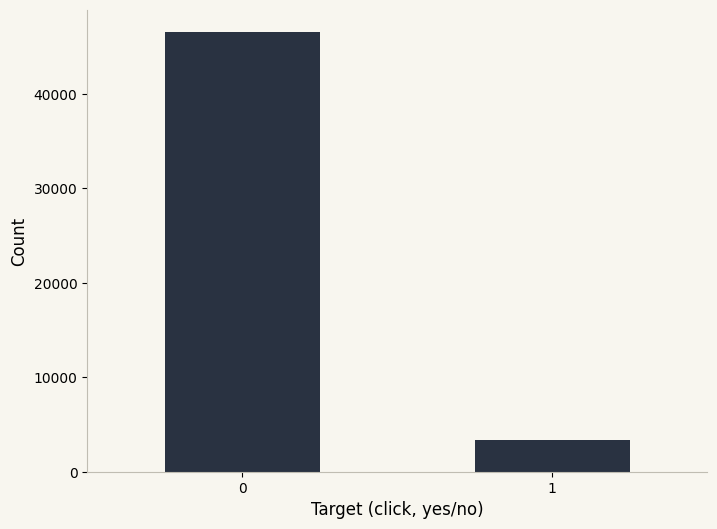

In [11]:
# Plotting bar graph with target (clicks) distribution
plot_bar(
    data=tech_df,
    x_column="y_click",
    xlabel="Target (click, yes/no)",
    ylabel="Count",
    plot_name="y_bar_count",
)

### Feature Engineering

In [12]:
# Creating new features
# For instance, interaction between Total_Past_Communications and Word_Count or Total_Links might be worth exploring.
# Some users might be more likely to click on a link if they've had more past communications and the email has more content or more links.
tech_df["Word_Links_Interact"] = tech_df["Word_Count"] * tech_df["Total_Links"]
tech_df["Comm_Link_Interact"] = (
    tech_df["Total_Past_Communications"] * tech_df["Total_Links"]
)
tech_df["Comm_Word_Interact"] = (
    tech_df["Total_Past_Communications"] * tech_df["Word_Count"]
)

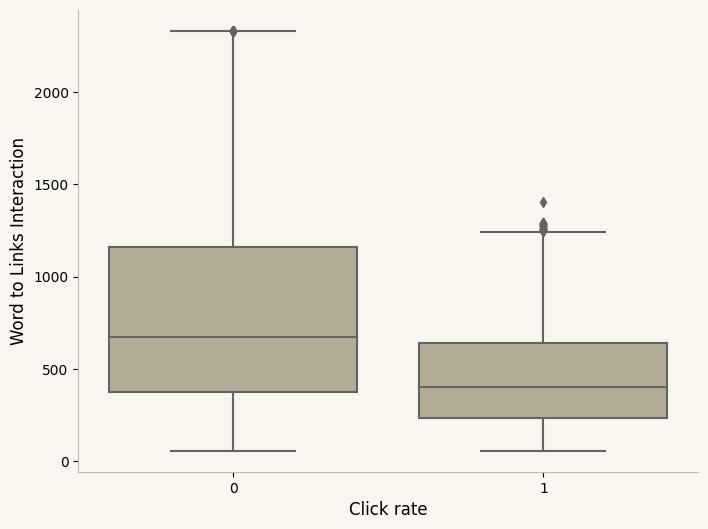

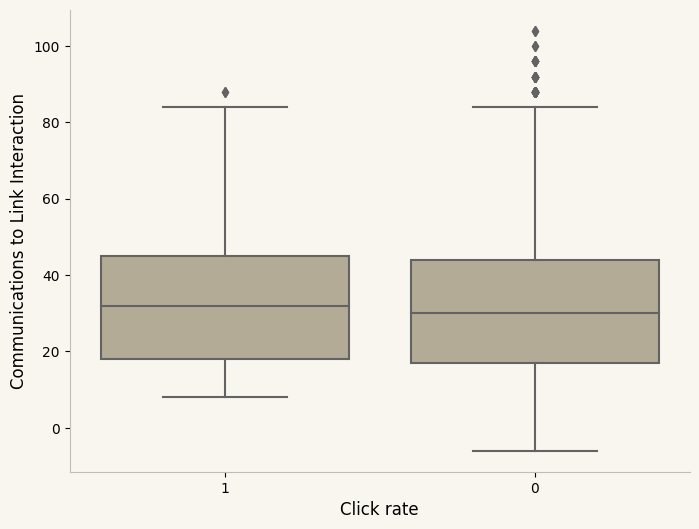

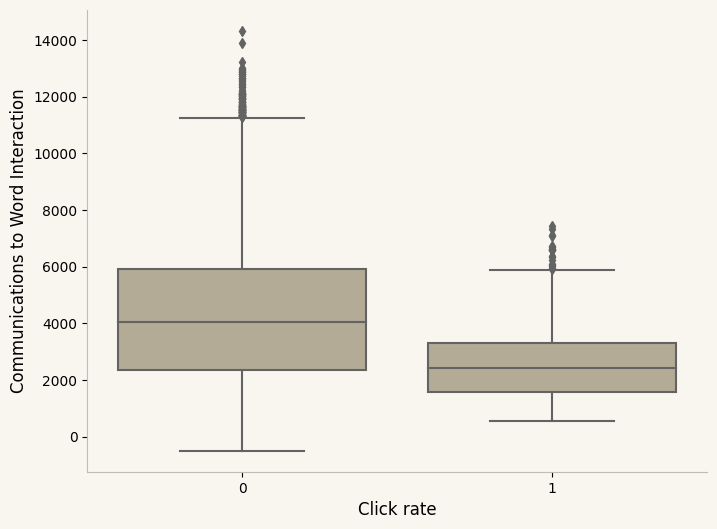

In [13]:
# Boxplot for Word_Links_Interact with y_click
plot_boxplot(
    tech_df,
    "y_click",
    "Word_Links_Interact",
    xlabel="Click rate",
    ylabel="Word to Links Interaction",
    plot_name="Word_Links_Interact_boxplot",
)
# Boxplot for Comm_Link_Interact with y_click
plot_boxplot(
    tech_df,
    "y_click",
    "Comm_Link_Interact",
    xlabel="Click rate",
    ylabel="Communications to Link Interaction",
    plot_name="Comm_Link_Interact_boxplot",
)
# Boxplot for Comm_Word_Interact with y_click
plot_boxplot(
    tech_df,
    "y_click",
    "Comm_Word_Interact",
    xlabel="Click rate",
    ylabel="Communications to Word Interaction",
    plot_name="Comm_Word_Interact_boxplot",
)

In [14]:
tech_df.groupby("y_click")["Word_Links_Interact"].mean()

y_click
0    822.413698
1    470.096121
Name: Word_Links_Interact, dtype: float64

In [15]:
tech_df.groupby("y_click")["Word_Links_Interact"].std()

y_click
0    557.021764
1    297.903362
Name: Word_Links_Interact, dtype: float64

In [19]:
# Categorize the Sent_Hour into parts of the day (morning, afternoon, evening, night) and see if that has any effect on the click-through rate
tech_df["Sent_Hour"] = tech_df["Sent_Hour"].str.slice(0, 2).astype(int)
tech_df["Part_Of_Day"] = pd.cut(
    tech_df["Sent_Hour"],
    bins=[-1, 6, 12, 18, 24],
    labels=["Night", "Morning", "Afternoon", "Evening"],
)

In [20]:
tech_df = tech_df.drop(columns=["Sent_Hour"])

In [21]:
# Statistical Tests
# Conduct hypothesis tests to evaluate whether the means of Word_Count, Total_Images or other continuous features differ significantly between clicked and non-clicked emails
# This can provide strong evidence that these features have an effect on the click-through rate
clicked = tech_df[tech_df["y_click"] == 1]
not_clicked = tech_df[tech_df["y_click"] == 0]

t, p = stats.ttest_ind(clicked["Word_Count"], not_clicked["Word_Count"])
print("Word_Count: t = ", t, "p = ", p)

t, p = stats.ttest_ind(clicked["Total_Images"], not_clicked["Total_Images"])
print("Total_Images: t = ", t, "p = ", p)

Word_Count: t =  -52.881829128089464 p =  0.0
Total_Images: t =  56.58528964703274 p =  0.0


### Clusterization

In [22]:
# Perform clusterization to find insights or meaningful data
numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]

# Define columns for each encoding
onehot_cols = ["Customer_Location", "Signup_Site", "Genre", "Browser"]
ordinal_cols = ["Part_Of_Day"]

X = tech_df.drop("y_click", axis=1)
numerics_cols = X.select_dtypes(include=numerics).columns

In [23]:
# Instantiate encoders
scaler = StandardScaler()
ordinal_enc = OrdinalEncoder()
onehot_enc = OneHotEncoder()

# Make a column transformer
preprocessor = make_column_transformer(
    (ordinal_enc, ordinal_cols),
    (onehot_enc, onehot_cols),
    (scaler, numerics_cols),
)

# Fit and transform on train, transform on test
X_preprocessed = preprocessor.fit_transform(X)

In [24]:
# Using the elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 31):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
    kmeans.fit(X_preprocessed)
    wcss.append(kmeans.inertia_)

/Users/LS/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/LS/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/LS/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/LS/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/LS/anaconda3/lib/python3.

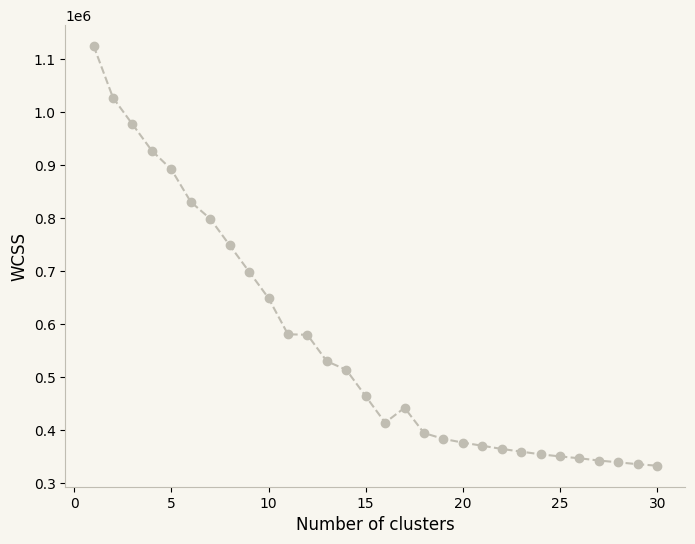

In [97]:
# Plotting the resultant graph to find the optimal number of clusters
plt.figure(figsize=(8, 6), facecolor=colors[-2])
plt.gca().set_facecolor(colors[-2])  # Set background color
for idx, spine in enumerate(plt.gca().spines.values()):
    if idx in [1, 3]:
        spine.set_visible(False)
    else:
        spine.set_edgecolor(colors[0])
plt.plot(range(1, 31), wcss, marker="o", linestyle="--", color=colors[0])
# plt.title('K-means Clustering: The Elbow Method')
plt.xlabel("Number of clusters", fontsize=12)
plt.ylabel("WCSS", fontsize=12)
plt.savefig(f"graphs_2/elbow_clustering.png", bbox_inches="tight", facecolor=colors[-2])
plt.show()

In [31]:
# We found that the mot optimal number of clusters is 18
kmeans = KMeans(n_clusters=18, random_state=0)
clusters = kmeans.fit_predict(X_preprocessed)

# Add the cluster number to the dataframe
tech_df["cluster"] = clusters

/Users/LS/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [32]:
groups_index = list(
    tech_df.groupby("cluster")["cluster"].count().sort_values(ascending=True).index
)
round(tech_df.groupby("cluster")["y_click"].mean().loc[groups_index], 2)

cluster
14    0.00
9     0.08
6     0.12
11    0.07
5     0.03
16    0.03
17    0.09
3     0.12
13    0.06
8     0.05
7     0.01
15    0.13
10    0.02
1     0.13
12    0.01
2     0.12
0     0.01
4     0.12
Name: y_click, dtype: float64

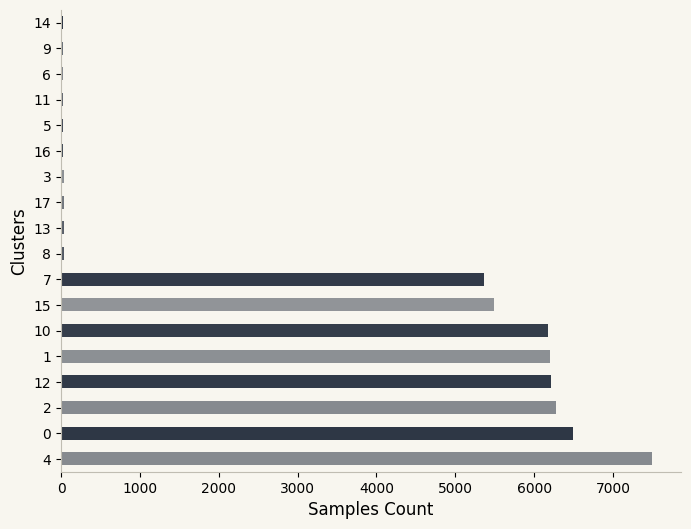

In [33]:
plot_bar(
    data=tech_df,
    x_column="cluster",
    bar_kind="barh",
    y_column="y_click",
    color_mapping=True,
    ylabel="Clusters",
    xlabel="Samples Count",
    plot_name="cluster_samples_count",
)

In [124]:
# add the cluster assignments back into the dataframe
tech_df["cluster_mean_values"] = kmeans.labels_

# Group by cluster
grouped = tech_df.groupby("cluster_mean_values")
tech_df = tech_df.drop(columns="cluster_mean_values")

# Compute mean value of each feature per cluster
mean_values = grouped.mean()

/var/folders/cz/4jxvc_4j2jn8zpdd258vcz7w0000gn/T/ipykernel_94321/2970116775.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_values = grouped.mean()


In [136]:
columns_for_clustering = [
    "Subject_Marketability_score",
    "Total_Past_Communications",
    "Word_Count",
    "Total_Links",
    "Total_Images",
    "y_click",
    "Word_Links_Interact",
    "Comm_Link_Interact",
    "Comm_Word_Interact",
    "cluster",
    "outlier",
]
large_clusters = [7, 15, 10, 1, 12, 2, 0, 4]

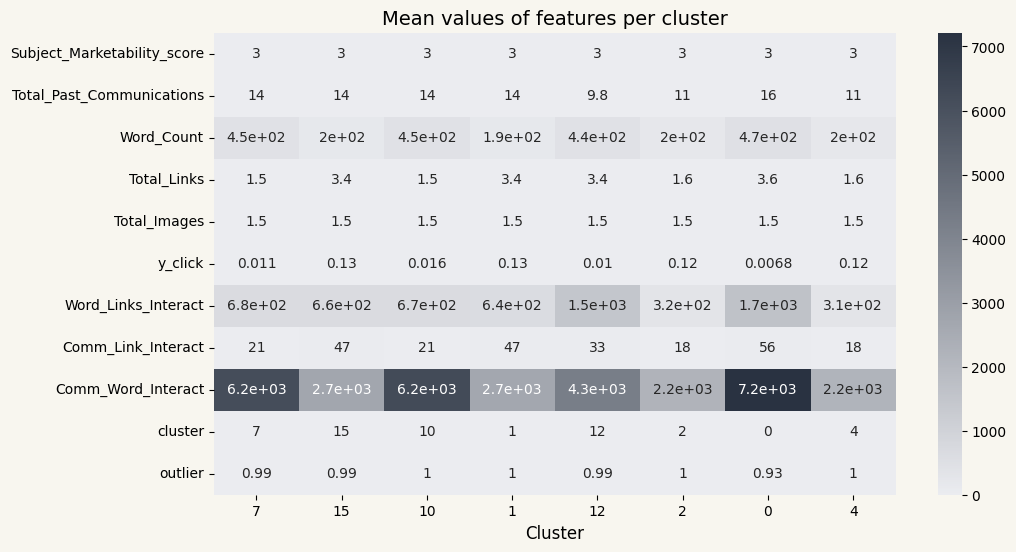

In [143]:
# Transpose the DataFrame for easier plotting
mean_values_t = mean_values.transpose()

# Plot mean values of features for each cluster
plt.figure(figsize=(11, 6), facecolor=colors[-2])
sns.heatmap(
    mean_values_t.loc[columns_for_clustering, large_clusters],
    cmap=custom_cmap_cluster,
    annot=True,
)
plt.title("Mean values of features per cluster", fontsize=14)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel(None)
plt.savefig(
    "graphs_2/mean_values_cluster.png", bbox_inches="tight", facecolor=colors[-2]
)
plt.show()

### Outliers

In [36]:
# Detecting outliers
# Let's use Isolation Forest this time
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination=0.007)
outliers = clf.fit_predict(X_preprocessed)

# Add the outlier predictions to the dataframe
tech_df["outlier"] = outliers

In [37]:
# Print outliers
tech_df.groupby(["outlier"])["y_click"].count()

outlier
-1      350
 1    49650
Name: y_click, dtype: int64

In [148]:
round(
    tech_df[
        [
            "Subject_Marketability_score",
            "Customer_Location",
            "Total_Past_Communications",
            "Word_Count",
            "Total_Links",
            "Total_Images",
            "Signup_Site",
            "Genre",
            "Browser",
            "y_click",
            "Word_Links_Interact",
            "Comm_Link_Interact",
            "Comm_Word_Interact",
            "Part_Of_Day",
            "cluster",
            "outlier",
        ]
    ].corr(),
    2,
)

/var/folders/cz/4jxvc_4j2jn8zpdd258vcz7w0000gn/T/ipykernel_94321/535903593.py:17: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  'outlier']].corr(), 2)


,Subject_Marketability_score,Total_Past_Communications,Word_Count,Total_Links,Total_Images,y_click,Word_Links_Interact,Comm_Link_Interact,Comm_Word_Interact,cluster,outlier
Subject_Marketability_score,1.00,-0.00,0.01,-0.00,0.00,0.13,0.01,-0.00,0.01,-0.00,-0.00
Total_Past_Communications,-0.00,1.00,0.00,0.00,-0.00,0.03,0.00,0.50,0.47,-0.12,-0.07
Word_Count,0.01,0.00,1.00,0.01,0.00,-0.23,0.69,0.00,0.85,0.13,-0.08
Total_Links,-0.00,0.00,0.01,1.00,-0.01,-0.01,0.65,0.84,0.00,0.05,-0.07
Total_Images,0.00,-0.00,0.00,-0.01,1.00,0.25,-0.00,-0.01,-0.00,0.01,-0.01
y_click,0.13,0.03,-0.23,-0.01,0.25,1.00,-0.16,0.01,-0.19,-0.03,0.02
Word_Links_Interact,0.01,0.00,0.69,0.65,-0.00,-0.16,1.00,0.55,0.59,0.04,-0.13
Comm_Link_Interact,-0.00,0.50,0.00,0.84,-0.01,0.01,0.55,1.00,0.24,-0.08,-0.11
Comm_Word_Interact,0.01,0.47,0.85,0.00,-0.00,-0.19,0.59,0.24,1.00,0.00,-0.12
cluster,-0.00,-0.12,0.13,0.05,0.01,-0.03,0.04,-0.08,0.00,1.00,0.05


/var/folders/cz/4jxvc_4j2jn8zpdd258vcz7w0000gn/T/ipykernel_94321/1999091328.py:110: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


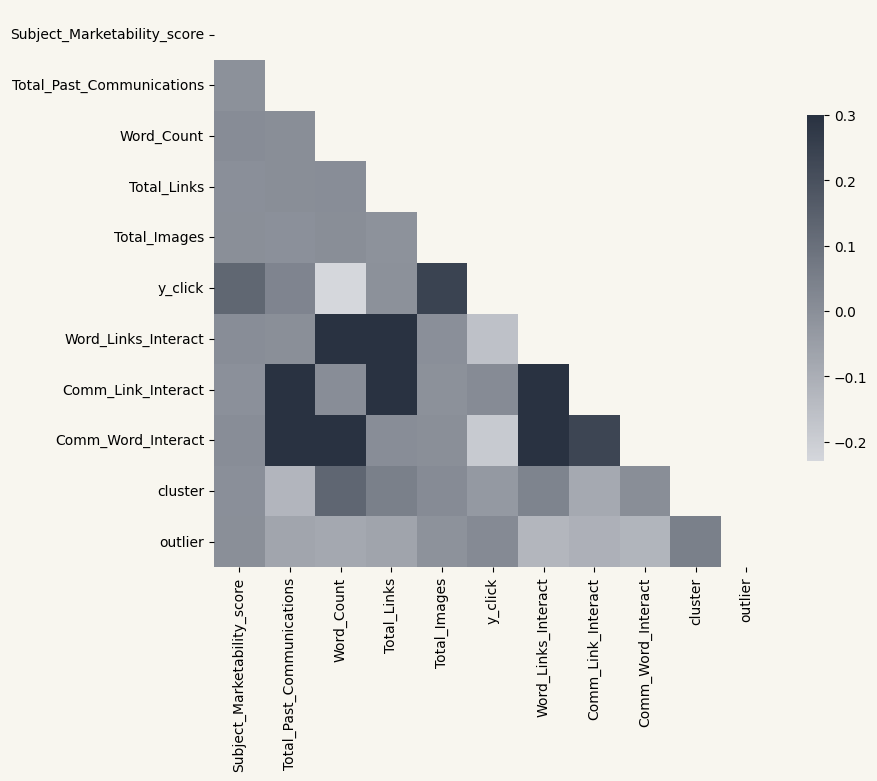

In [38]:
# Bivariate Analysis
# Correlation
plot_corr(
    tech_df[
        [
            "Subject_Marketability_score",
            "Customer_Location",
            "Total_Past_Communications",
            "Word_Count",
            "Total_Links",
            "Total_Images",
            "Signup_Site",
            "Genre",
            "Browser",
            "y_click",
            "Word_Links_Interact",
            "Comm_Link_Interact",
            "Comm_Word_Interact",
            "Part_Of_Day",
            "cluster",
            "outlier",
        ]
    ],
    mask=True,
    plot_name="feature_corr",
)

### Dimentionality Reduction

In [39]:
# Define columns for each encoding
onehot_cols = ["Customer_Location", "Signup_Site", "Genre", "Browser", "cluster"]
ordinal_cols = ["Part_Of_Day"]

X = tech_df.drop("y_click", axis=1)
numerics_cols = X.select_dtypes(include=numerics).columns

# Instantiate encoders
scaler = StandardScaler()
ordinal_enc = OrdinalEncoder()
onehot_enc = OneHotEncoder()

# Make a column transformer
preprocessor = make_column_transformer(
    (ordinal_enc, ordinal_cols),
    (onehot_enc, onehot_cols),
    (scaler, numerics_cols),
)

# Fit and transform on train, transform on test
X_preprocessed = preprocessor.fit_transform(X)

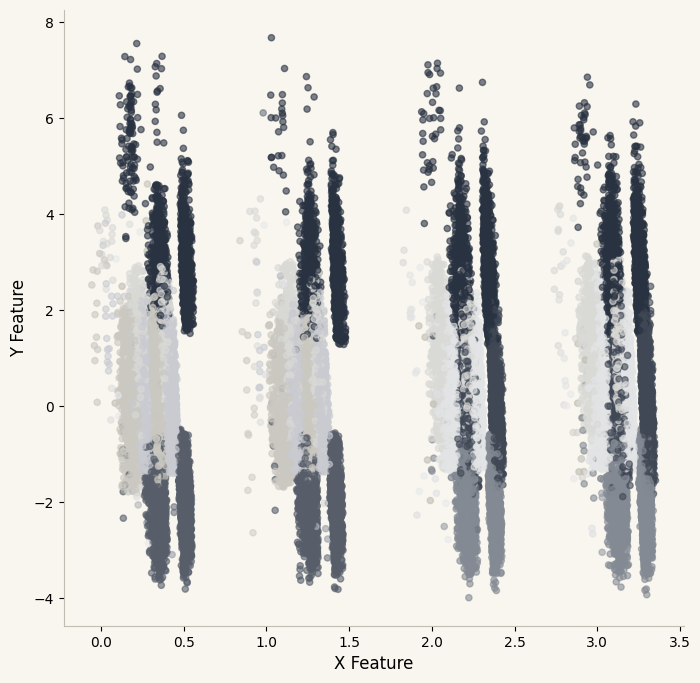

In [41]:
# Let's visualize dimentionality reduction with SVD
tsvd_2 = TruncatedSVD(n_components=2)
X_tsvd_2 = tsvd_2.fit_transform(X_preprocessed)

fig = plt.figure(figsize=(8, 8), facecolor=colors[-2])
ax = fig.add_subplot(111)

# Set the background color
ax.set_facecolor(colors[-2])

# Remove background grid and frame lines
for idx, spine in enumerate(plt.gca().spines.values()):
    if idx in [1, 3]:
        spine.set_visible(False)
    else:
        spine.set_edgecolor(colors[0])

# Scatter plot
sc = ax.scatter(
    X_tsvd_2[:, 0],
    X_tsvd_2[:, 1],
    c=tech_df["cluster"],
    cmap=custom_cmap,
    alpha=0.6,
    s=20,
)

# Legend
# Produces a legend for the colors used in the scatter plot
# legend1 = ax.legend(*sc.legend_elements(), title="Clusters")
# ax.add_artist(legend1)

# Axes labels
ax.set_xlabel("X Feature", fontsize=12)
ax.set_ylabel("Y Feature", fontsize=12)

# Title
# ax.set_title("Truncated SVD in 2D", pad=20)

plt.savefig(f"graphs_2/truncatedsvd_2d.png", bbox_inches="tight")
plt.show()

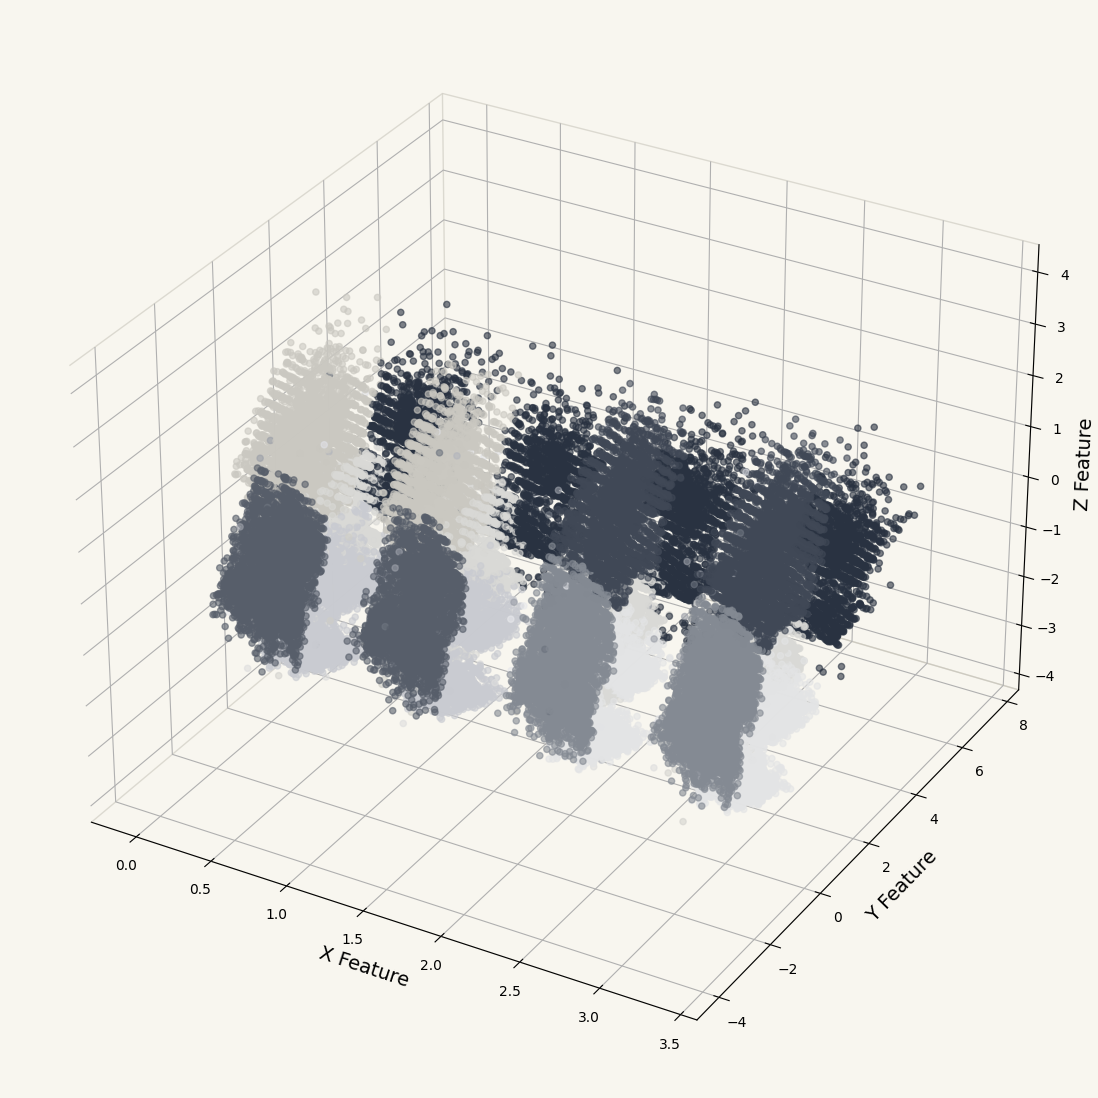

In [42]:
# Let's visualize dimentionality reduction with SVD
tsvd = TruncatedSVD(n_components=3)
X_tsvd = tsvd.fit_transform(X_preprocessed)

fig = plt.figure(figsize=(16, 14), facecolor=colors[-2])
ax = fig.add_subplot(111, projection="3d")

# Set the background color
ax.set_facecolor(colors[-2])

# Remove background grid and frame lines
ax.grid(True)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor(colors[0])
ax.yaxis.pane.set_edgecolor(colors[0])
ax.zaxis.pane.set_edgecolor(colors[0])

# Scatter plot
sc = ax.scatter(
    X_tsvd[:, 0],
    X_tsvd[:, 1],
    X_tsvd[:, 2],
    c=tech_df["cluster"],
    cmap=custom_cmap,
    alpha=0.6,
    s=20,
)

# Axes labels
ax.set_xlabel("X Feature", fontsize=14)
ax.set_ylabel("Y Feature", fontsize=14)
ax.set_zlabel("Z Feature", fontsize=14)

# Title
# ax.set_title("Truncated SVD in 3D", pad=20)

plt.savefig(f"graphs_2/truncatedsvd_3d.png", bbox_inches="tight")
plt.show()

In [99]:
# Apply TruncatedSVD with a large number of components, let's say 100
svd = TruncatedSVD(n_components=40)
X_transformed = svd.fit_transform(X_preprocessed)

# Calculate the explained variance ratios
explained_variance = svd.explained_variance_ratio_.cumsum()

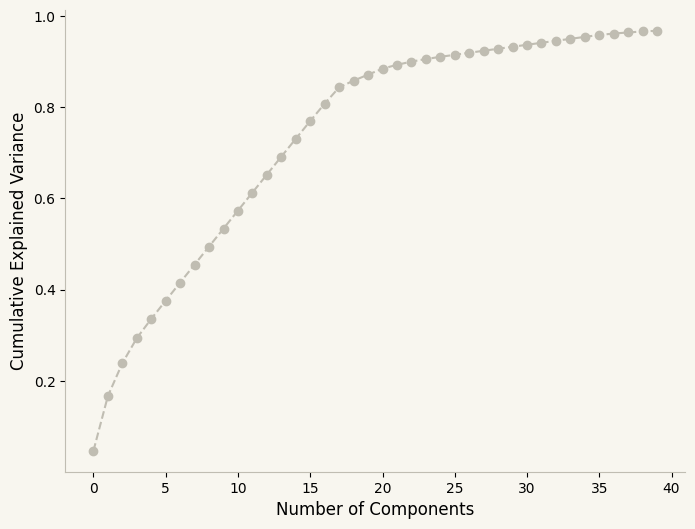

In [101]:
plt.figure(figsize=(8, 6), facecolor=colors[-2])
plt.gca().set_facecolor(colors[-2])  # Set background color
# Plot the explained variance
# Remove background grid and frame lines
for idx, spine in enumerate(plt.gca().spines.values()):
    if idx in [1, 3]:
        spine.set_visible(False)
    else:
        spine.set_edgecolor(colors[0])
plt.plot(
    range(len(explained_variance)),
    explained_variance,
    marker="o",
    linestyle="--",
    color=colors[0],
)
plt.xlabel("Number of Components", fontsize=12)
plt.ylabel("Cumulative Explained Variance", fontsize=12)
plt.savefig(f"graphs_2/svd_variance.png", bbox_inches="tight", facecolor=colors[-2])
plt.show()

In [50]:
svd = TruncatedSVD(n_components=20)
X_transformed = svd.fit_transform(X_preprocessed)
# Create a dataframe from the SVD transformed data
svd_df = pd.DataFrame(X_transformed, columns=[f"svd_{i}" for i in range(20)])

# Reset the index of tech_df
tech_df_reset = tech_df.reset_index(drop=True)

# Concatenate the original dataframe with the new svd dataframe
tech_df = pd.concat([tech_df_reset, svd_df], axis=1)

### Modeling

In [102]:
X = tech_df.drop("y_click", axis=1)
y = tech_df["y_click"]

In [103]:
# First, split into training and holdout sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.12, stratify=y, random_state=0
)

# Then split the training set further into training and validation sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.12, random_state=0)
for train_index, val_index in sss.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

In [104]:
onehot_cols = ["Customer_Location", "Signup_Site", "Genre", "Browser", "cluster"]
numerics_cols = X.select_dtypes(include=numerics).columns.drop("cluster")

In [105]:
# Define preprocessor
preprocessor = ColumnTransformer(
    # Make a column transformer
    transformers=[
        # Instantiate encoders
        ("num", StandardScaler(), numerics_cols),
        ("onehot", OneHotEncoder(drop="first"), onehot_cols),
        ("ordinal", OrdinalEncoder(), ordinal_cols),
    ]
)

# Define classifiers
classifiers = [
    ("rf", RandomForestClassifier()),
    ("gb", GradientBoostingClassifier()),
    ("sgd", SGDClassifier()),
    ("xgb", XGBClassifier()),
    ("lgbm", LGBMClassifier()),
]


# Define feature selectors
selectors = [
    ("sfm", SelectFromModel(estimator=XGBClassifier())),
    ("skb", SelectKBest(score_func=f_classif, k=10)),
]

# Define resampling
custom_kmeans = KMeans(n_init=3, n_clusters=18)
resampling = KMeansSMOTE(
    random_state=0,
    sampling_strategy=0.1,
    kmeans_estimator=custom_kmeans,
    cluster_balance_threshold=0.1,
)

# Define pipelines
pipelines = {}
for classifier_name, classifier in classifiers:
    # Pipeline without feature selection
    pipelines[f"{classifier_name}"] = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("sampler", resampling),
            ("classifier", classifier),
        ]
    )
    for selector_name, selector in selectors:
        # Pipelines with feature selection
        pipelines[f"{classifier_name}_{selector_name}"] = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("sampler", resampling),
                ("selector", selector),
                ("classifier", classifier),
            ]
        )

In [106]:
# Define parameter grid
param_grids = {
    "rf": {
        # 'sampler__sampling_strategy': [0.1, 0.2, 0.3],
        # 'sampler__k_neighbors': [5, 8],
        "classifier__class_weight": ["balanced"],
        "classifier__n_estimators": [20, 100, 200],
        # 'classifier__max_features': ['sqrt', 'log2'],
    },
    # 'rf_sfm': {
    #     'sampler__sampling_strategy': [0.1, 0.2, 0.3],
    #     'sampler__k_neighbors': [5, 8],
    #     'selector__estimator__n_estimators': [5, 10],
    #     'classifier__class_weight': ['balanced'],
    #     'classifier__n_estimators': [5, 20, 100],
    #     'classifier__max_features': ['sqrt', 'log2'],
    # },
    # 'rf_skb': {
    # 'sampler__sampling_strategy': [0.1, 0.2, 0.3],
    # 'sampler__k_neighbors': [5, 8],
    # 'selector__k': [5, 10],
    # 'classifier__class_weight': ['balanced'],
    # 'classifier__n_estimators': [20, 100, 200],
    # 'classifier__max_features': ['sqrt', 'log2'],
    # },
    "gb": {
        # 'sampler__sampling_strategy': [0.1, 0.2, 0.3],
        # 'sampler__k_neighbors': [5, 8],
        # 'classifier__max_depth': [3, 5],
        "classifier__n_estimators": [20, 100, 200],
        "classifier__learning_rate": [0.001, 0.01, 0.1],
    },
    # 'gb_sfm': {
    #     'sampler__sampling_strategy': [0.1, 0.2, 0.3],
    #     'selector__estimator__n_estimators': [5, 10],
    #     'classifier__max_depth': [3, 5],
    #     'classifier__n_estimators': [5, 20, 100],
    #     'classifier__learning_rate': [0.001, 0.01, 0.1, 1],
    # },
    # 'gb_skb': {
    #     'sampler__sampling_strategy': [0.1, 0.2, 0.3],
    #     'selector__k': [5, 10],
    #     'classifier__max_depth': [3, 5],
    #     'classifier__n_estimators': [5, 20, 100],
    #     'classifier__learning_rate': [0.001, 0.01, 0.1, 1],
    # },
    # 'sgd': {
    #     # 'sampler__sampling_strategy': [0.1, 0.2, 0.3],
    #     'classifier__alpha': [0, 0.0001, 0.001],
    #     'classifier__penalty': ['l2', 'l1'],
    #     'classifier__class_weight': ['balanced']
    # },
    # 'sgd_sfm': {
    #     # 'sampler__sampling_strategy': [0.1, 0.2, 0.3],
    #     'selector__estimator__n_estimators': [5, 10],
    #     'classifier__alpha': [0, 0.0001, 0.001],
    #     'classifier__penalty': ['l2', 'l1'],
    #     'classifier__class_weight': ['balanced']
    # },
    # 'sgd_skb': {
    #     # 'sampler__sampling_strategy': [0.1, 0.2, 0.3],
    #     'selector__k': [5, 10],
    #     'classifier__alpha': [0, 0.0001, 0.001],
    #     'classifier__penalty': ['l2', 'l1'],
    #     'classifier__class_weight': ['balanced']
    # },
    "xgb": {
        # 'sampler__sampling_strategy': [0.1, 0.2, 0.3],
        # 'sampler__k_neighbors': [5, 8],
        "classifier__n_estimators": [20, 100, 200],
        "classifier__learning_rate": [0.001, 0.01, 0.1],
        "classifier__scale_pos_weight": [15],
    },
    # 'xgb_sfm': {
    #     'sampler__sampling_strategy': [0.1, 0.2, 0.3],
    #     'sampler__k_neighbors': [5, 8],
    #     'selector__estimator__n_estimators': [5, 10, 20],
    #     'classifier__n_estimators': [5, 20, 100],
    #     'classifier__learning_rate': [0.001, 0.01, 0.1, 1],
    #     'classifier__scale_pos_weight': [1, 10],
    # },
    # 'xgb_skb': {
    #     'sampler__sampling_strategy': [0.1, 0.2, 0.3],
    #     'sampler__k_neighbors': [5, 8],
    #     'selector__k': [5, 10],
    #     'classifier__n_estimators': [5, 20, 100],
    #     'classifier__learning_rate': [0.001, 0.01, 0.1, 1],
    #     'classifier__scale_pos_weight': [1, 10],
    # },
    "lgbm": {
        # 'sampler__sampling_strategy': [0.1, 0.2, 0.3],
        # 'sampler__k_neighbors': [5, 8],
        "classifier__n_estimators": [20, 100, 200],
        "classifier__learning_rate": [0.001, 0.01, 0.1],
        "classifier__class_weight": ["balanced"],
    },
    # 'lgbm_sfm': {
    #     'sampler__sampling_strategy': [0.1, 0.2, 0.3],
    #     'sampler__k_neighbors': [5, 8],
    #     'selector__estimator__n_estimators': [5, 10, 20],
    #     'classifier__n_estimators': [5, 20, 100],
    #     'classifier__learning_rate': [0.001, 0.01, 0.1, 1],
    #     'classifier__class_weight': ['balanced']
    # },
    # 'lgbm_skb': {
    #     'sampler__sampling_strategy': [0.1, 0.2, 0.3],
    #     'sampler__k_neighbors': [5, 8],
    #     'selector__k': [5, 10],
    #     'classifier__n_estimators': [5, 20, 100],
    #     'classifier__learning_rate': [0.001, 0.01, 0.1, 1],
    #     'classifier__class_weight': ['balanced']
    # },
}

In [107]:
# Define the inner and outer cross-validation
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = StratifiedShuffleSplit(n_splits=5, random_state=0)

# Create a custom precision scorer
def custom_precision(y_true, y_pred):
    return precision_score(y_true, y_pred, zero_division=0)


# Create a custom recall scorer
def custom_recall(y_true, y_pred):
    return recall_score(y_true, y_pred, zero_division=0)


# Wrap the custom precision function in make_scorer
custom_precision_scorer = make_scorer(custom_precision)
custom_recall_scorer = make_scorer(custom_recall)

inner_scoring = "recall"
outter_scoring = "recall"

# Define pipelines and grid searches
grid_searches = {}
time_records = {}

# Progress bar setup
pbar = tqdm(total=len(param_grids), desc="Model Fitting Progress", dynamic_ncols=True)

for pipeline_name, pipeline in pipelines.items():
    start_time = time.time()

    if pipeline_name in param_grids:
        # Grid search with inner CV
        grid_search = GridSearchCV(
            pipeline,
            param_grids[pipeline_name],
            scoring=custom_recall_scorer,
            cv=inner_cv,
            n_jobs=-1,
        )
        grid_search.fit(X_train, y_train)
        grid_searches[pipeline_name] = grid_search
        mean_inner_score = grid_search.cv_results_["mean_test_score"].mean()
        print(
            f"GridSearchCV Score ({inner_scoring}) for {pipeline_name}: {round(mean_inner_score, 3)}"
        )

        # Nested cross-validation with outer CV
        nested_score = cross_val_score(
            grid_search.best_estimator_,
            X_val,
            y_val,
            cv=outer_cv,
            scoring=outter_scoring,
        )
        print(f"Nested CV Score ({outter_scoring}): {round(nested_score.mean(), 3)}")

        # Main metrics on Test data
        print(
            f"Metrics for Test Data: accuracy = {round(accuracy_score(grid_search.predict(X_test), y_test), 3)} \n \
                      precision = {round(precision_score(grid_search.predict(X_test), y_test), 3)} \n \
                      recall = {round(recall_score(grid_search.predict(X_test), y_test), 3)}"
        )
    else:
        continue

    end_time = time.time()
    elapsed_time = end_time - start_time
    time_records[pipeline_name] = elapsed_time
    # Display computational times
    print(f"Time taken for {pipeline_name}: {round(elapsed_time, 2)} seconds")
    print()

    # Update progress bar
    pbar.update(1)

# Close progress bar
pbar.close()

Model Fitting Progress:   0%|                             | 0/4 [00:00<?, ?it/s]

GridSearchCV Score (recall) for rf: 0.456
Nested CV Score (recall): 0.433
Metrics for Test Data: accuracy = 0.932 
                       precision = 0.461 
                       recall = 0.499
Time taken for rf: 57.74 seconds

GridSearchCV Score (recall) for gb: 0.166
Nested CV Score (recall): 0.539
Metrics for Test Data: accuracy = 0.936 
                       precision = 0.797 
                       recall = 0.518
Time taken for gb: 712.08 seconds

GridSearchCV Score (recall) for xgb: 0.991
Nested CV Score (recall): 0.967
Metrics for Test Data: accuracy = 0.933 
                       precision = 0.995 
                       recall = 0.504
Time taken for xgb: 509.35 seconds

GridSearchCV Score (recall) for lgbm: 0.982
Nested CV Score (recall): 0.967
Metrics for Test Data: accuracy = 0.933 
                       precision = 1.0 
                       recall = 0.503
Time taken for lgbm: 36.4 seconds



In [126]:
# Save each GridSearchCV object
for name, grid_search in grid_searches.items():
    with open(f"models/{name}_grid_search.pkl", "wb") as f:
        pickle.dump(grid_search, f)

In [56]:
def open_model(name):
    with open(f"models/{name}_grid_search.pkl", "rb") as f:
        loaded_grid_search = pickle.load(f)
    return loaded_grid_search

{'classifier__class_weight': 'balanced', 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 5, 'sampler__k_neighbors': 5, 'sampler__sampling_strategy': 0.2}


In [110]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers."""
    output_features = []

    # Loop through all transformers in the ColumnTransformer
    for name, pipe, features in column_transformer.transformers_:
        if name != "remainder":
            # If one-hot encoder
            if name == "onehot":
                for feature in pipe.get_feature_names_out():
                    output_features.append(feature)
            # Else, simply convert the selected features to a list and append
            else:
                output_features += list(features)

    return output_features

In [115]:
def plot_feature_importance(
    importance,
    names,
    features_to_plot=10,
    bar_kind="barh",
    figsize=(8, 6),
    plot_name=None,
    **kwargs,
):

    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Create a DataFrame using a Dictionary
    data = {"feature_names": feature_names, "feature_importance": feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=["feature_importance"], ascending=False, inplace=True)

    # Select top features
    fi_df = fi_df.head(features_to_plot)

    # Define size of bar plot
    plt.figure(facecolor=kwargs.get("background_color", colors[-2]), figsize=figsize)
    plt.gca().set_facecolor(
        kwargs.get("background_color", colors[-2])
    )  # Set background color
    for idx, spine in enumerate(plt.gca().spines.values()):
        if idx in [1, 3]:
            spine.set_visible(False)
        else:
            spine.set_edgecolor(kwargs.get("spine_color", colors[0]))

    if bar_kind == "barh":
        plt.barh(
            fi_df["feature_names"],
            fi_df["feature_importance"],
            color=kwargs.get("linear_color_0", colors[1]),
        )
    else:
        plt.bar(
            fi_df["feature_names"],
            fi_df["feature_importance"],
            color=kwargs.get("linear_color_0", colors[1]),
        )

    plt.xticks(
        fontsize=kwargs.get("xtick_fontsize", 10),
        rotation=kwargs.get("xtick_rotation", "horizontal"),
    )
    plt.yticks(
        range(0, features_to_plot),
        fi_df["feature_names"].values,
        fontsize=kwargs.get("ytick_fontsize", 10),
        rotation=kwargs.get("ytick_rotation", "horizontal"),
    )
    plt.xlabel("Feature Importance", fontsize=kwargs.get("xlabel_fontsize", 12))
    plt.ylabel(None)
    if plot_name:
        plt.savefig(
            f"graphs_2/{plot_name}_feature_importance.png",
            bbox_inches="tight",
            facecolor=kwargs.get("background_color", colors[-2]),
        )
    plt.show()

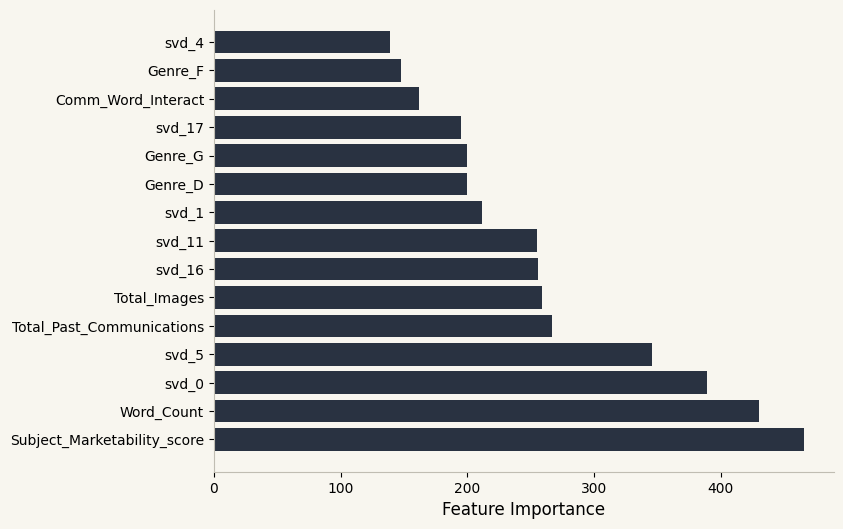

In [119]:
# Assuming you have a fitted random forest model in your grid_searches dictionary
rf_model = grid_searches["lgbm"].best_estimator_
# And the feature names are stored in a list or array feature_names
feature_names = get_feature_names(rf_model.named_steps["preprocessor"])
plot_feature_importance(
    rf_model.named_steps["classifier"].feature_importances_,
    feature_names,
    features_to_plot=15,
    plot_name="lgbm",
)